# Prediction

## Modifying Model Input Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [477]:
model_input = pd.read_csv("model_input_clean.csv")

In [478]:
model_input["patent_id"] = model_input["patent_id"].astype(str)
model_input = model_input.drop(columns=["Unnamed: 0"], axis=1)

In [480]:
model_input.head()

,patent_id,count,grant_year,num_claims,application_year,assignee_type,class_size,backward_citations,novelty,circulation,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,pendency
0,10000017,1,2018.0,21,2015.0,3.0,11.079678,0.0,1,4.0,...,0,0,0,0,0,1,0,0,0,3.0
1,10000033,3,2018.0,20,2015.0,2.0,11.079678,0.0,2,4.0,...,0,0,0,0,0,1,0,0,0,3.0
2,10025115,1,2018.0,14,2016.0,3.0,11.079678,0.0,1,4.0,...,0,0,0,0,0,1,0,0,0,2.0
3,10029937,2,2018.0,14,2015.0,3.0,11.079678,0.0,1,4.0,...,0,0,0,0,0,1,0,0,0,3.0
4,10058890,1,2018.0,14,2016.0,2.0,11.079678,3.0,1,4.0,...,0,0,0,0,0,1,0,0,0,2.0


In [481]:
# take the patents whose application year is between 1975-2022
model_input = model_input[(model_input["application_year"]>=1975) & (model_input["application_year"] <= 2022)]

In [482]:
# a small change in the novelty measure.
model_input["novelty_score"] = model_input["novelty"]/model_input["count"]

In [483]:
model_input.to_csv("model_input_final.csv")

In [484]:
model_input_no_dummy = model_input[["count", "num_claims","class_size","backward_citations","novelty_score","pendency","circulation"]]
model_input_no_dummy.describe().T

,count,mean,std,min,25%,50%,75%,max
count,75174.0,17.950821,41.100944,1.000000,3.000000,7.000000,18.000000,1787.000000
num_claims,75174.0,15.645303,11.824106,1.000000,8.000000,14.000000,20.000000,299.000000
class_size,75174.0,12.247371,0.919706,2.397895,11.643875,12.122446,13.252762,13.668709
backward_citations,75174.0,1.468101,7.091387,0.000000,0.000000,0.000000,1.000000,311.000000
novelty_score,75174.0,0.560535,0.355782,0.000000,0.250000,0.600000,0.909091,1.000000
pendency,75174.0,2.574268,1.565677,0.000000,2.000000,2.000000,3.000000,16.000000
circulation,75174.0,20.854551,12.233940,0.000000,10.000000,20.000000,30.000000,46.000000


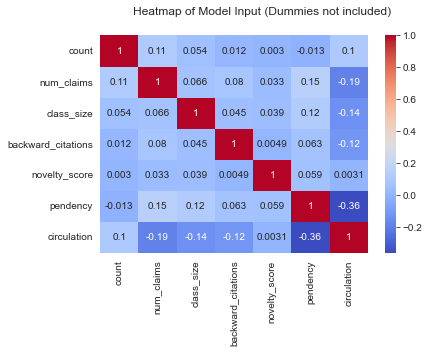

In [485]:
#heatmap
fig = plt.figure()
sns.heatmap(model_input_no_dummy.corr(), annot=True, cmap='coolwarm');
fig.suptitle('Heatmap of Model Input (Dummies not included)')
plt.savefig("heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

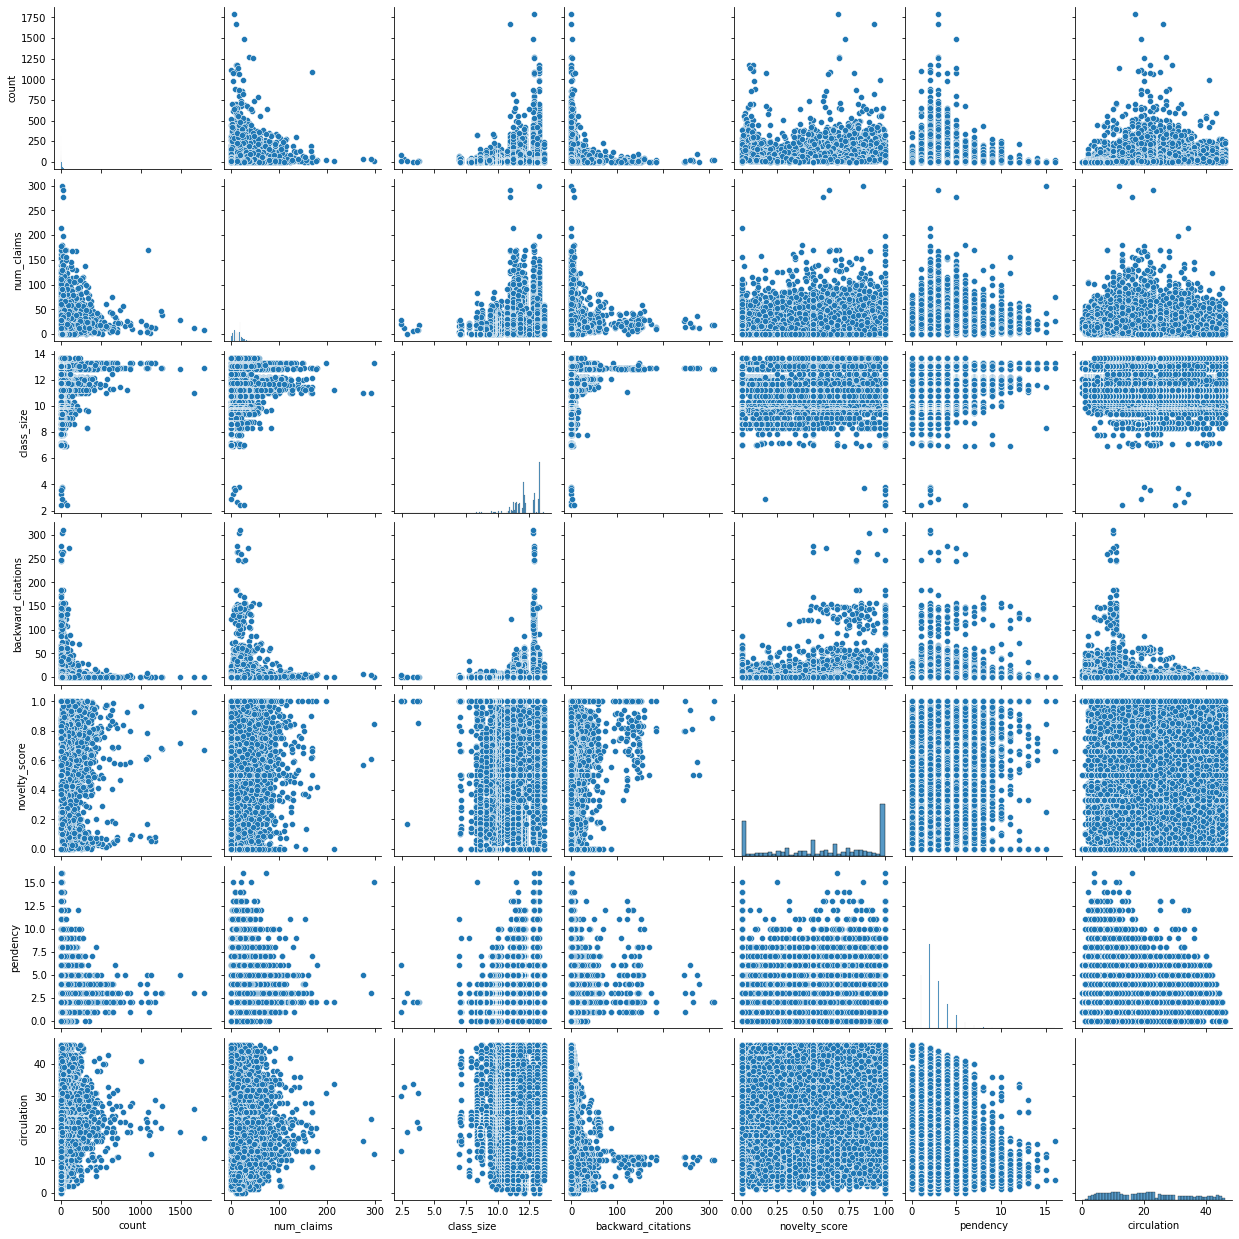

In [93]:
#pairplot
sns.pairplot(model_input_no_dummy);

# Classification
First, let us consider this problem as a multiclass classification problem

In [486]:
# I will use the data between 1975-2002 for training and testing; 2003-2022 for prediction.
model_input_traintest = model_input[(model_input["application_year"]>=1975) & (model_input["application_year"]<=2002)]

#model_input_traintest = model_input_traintest.drop(columns=["patent_id", "count", "application_year"],axis=1)

model_input_predict = model_input[(model_input["application_year"]>=2003) & (model_input["application_year"]<=2022)]
#model_input_predict = model_input_predict.drop(columns=["patent_id", "count", "application_year"], axis=1)

In [487]:
# I will classify citation counts as low, medium, and high. 0-50 percentile: low, 50-75: medium, 75-100: high.
# In this part I am using the truncated part of the data since it would decrease the percentiles.

percentile_75 = model_input_traintest['count'].quantile(0.75)
percentile_50 = model_input_traintest['count'].quantile(0.50)

# create a new column to store the classification
model_input_traintest['classification'] = 0
model_input_traintest.loc[model_input_traintest['count'] >= percentile_75, 'classification'] = 2
model_input_traintest.loc[(model_input_traintest['count'] >= percentile_50) & (model_input_traintest['count'] < percentile_75), 'classification'] = 1

# Doing this for the truncated part
percentile_75_t = model_input_predict['count'].quantile(0.75)
percentile_50_t= model_input_predict['count'].quantile(0.50)

model_input_predict['classification'] = 0
model_input_predict.loc[model_input_predict['count'] >= percentile_75, 'classification'] = 2
model_input_predict.loc[(model_input_predict['count'] >= percentile_50) & (model_input_predict['count'] < percentile_75), 'classification'] = 1

In [488]:
model_input_traintest

,patent_id,count,grant_year,num_claims,application_year,assignee_type,class_size,backward_citations,novelty,circulation,...,2015,2016,2017,2018,2019,2020,2021,pendency,novelty_score,classification
57,3941537,23,1976.0,6,1975.0,2.0,11.079678,0.0,23,46.0,...,0,0,0,0,0,0,0,1.0,1.000000,1
58,3969050,2,1976.0,5,1975.0,2.0,11.079678,0.0,0,46.0,...,0,0,0,0,0,0,0,1.0,0.000000,0
59,3979168,12,1976.0,8,1975.0,3.0,11.079678,0.0,11,46.0,...,0,0,0,0,0,0,0,1.0,0.916667,1
60,3996085,9,1976.0,12,1975.0,2.0,11.079678,0.0,5,46.0,...,0,0,0,0,0,0,0,1.0,0.555556,0
61,3998918,2,1976.0,2,1976.0,2.0,11.079678,0.0,2,46.0,...,0,0,0,0,0,0,0,0.0,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75168,D448412,3,2001.0,1,1999.0,3.0,7.890583,2.0,3,21.0,...,0,0,0,0,0,0,0,2.0,1.000000,0
75169,D451959,5,2001.0,1,2001.0,2.0,7.890583,0.0,4,21.0,...,0,0,0,0,0,0,0,0.0,0.800000,0
75170,D464189,8,2002.0,1,2001.0,2.0,9.356603,0.0,0,20.0,...,0,0,0,0,0,0,0,1.0,0.000000,0
75171,D473755,10,2003.0,1,2002.0,3.0,9.356603,0.0,1,19.0,...,0,0,0,0,0,0,0,1.0,0.100000,0


In [489]:
X = model_input_traintest.drop(["grant_year","classification","patent_id","count","novelty"],axis=1)
y = model_input_traintest["classification"]

In [490]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=21)

### Importing necessary libraries

In [32]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve
import statsmodels.formula.api as smf
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [379]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [33]:
from warnings import filterwarnings
filterwarnings('ignore')

# KNN

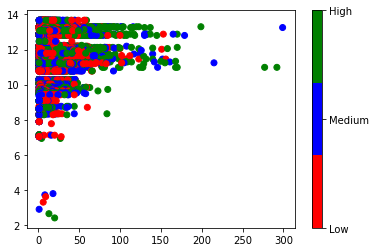

In [55]:
# let us draw a scatterplot 
from matplotlib.colors import ListedColormap
colors = ListedColormap(['red', 'blue', 'green'])
plt.scatter(model_input_traintest["num_claims"], model_input_traintest["class_size"], c=model_input_traintest["classification"], cmap=colors)
cbar = plt.colorbar()
cbar.set_ticks([0, 1, 2])
cbar.set_ticklabels(['Low', 'Medium', 'High'])
plt.show()

In [491]:
knn = KNeighborsClassifier()
knn_model = knn.fit(X_train, y_train)

In [492]:
y_pred = knn_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.4500857377171401

In [493]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.72      0.60      6529
           1       0.28      0.20      0.23      3519
           2       0.37      0.19      0.25      3365

    accuracy                           0.45     13413
   macro avg       0.39      0.37      0.36     13413
weighted avg       0.42      0.45      0.42     13413



### KNN Model Tuning

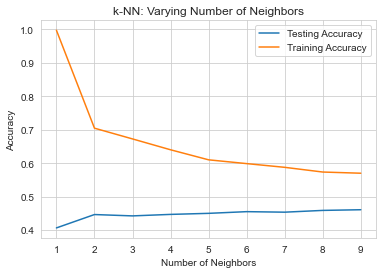

In [494]:
# Setup arrays to store train and test accuracies
# This code is from lecture codes: ML1
neighbors = np.arange(1, 10)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [495]:
# 10-fold CV
knn_params = {"n_neighbors": np.arange(1,10)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, knn_params, cv=10)
knn_cv.fit(X_train, y_train)
print("Best score:" + str(knn_cv.best_score_))
print("Best parameters: " + str(knn_cv.best_params_))

Best score:0.4639225242169257
Best parameters: {'n_neighbors': 9}


In [496]:
# tuned model
knn = KNeighborsClassifier(9)
knn_tuned = knn.fit(X_train, y_train)

#checking for overfitting
knn_tuned.score(X_test, y_test)

0.46089614553045555

In [497]:
knn_tuned.score(X_train,y_train)

0.5700134211030868

In [498]:
y_pred = knn_tuned.predict(X_test)

In [499]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.75      0.61      6529
           1       0.28      0.15      0.20      3519
           2       0.38      0.22      0.28      3365

    accuracy                           0.46     13413
   macro avg       0.39      0.37      0.36     13413
weighted avg       0.42      0.46      0.42     13413



# SVM

In [500]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.30, 
                                                    random_state=42)
svm_model = SVC(kernel = "rbf").fit(X_train, y_train) #Probably, my dataset is non-linear, so I use RBF.
y_pred = svm_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.4869902333556997

### SVM Model Tuning

In [501]:
# it took a lot of time to do a 10-fold cross-validation. Instead I do 3-fold CV here.
svc_params = {"C": np.arange(1,5)}

svc = SVC(kernel = "linear")

svc_cv_model = GridSearchCV(svc,svc_params, 
                            cv = 3, 
                            n_jobs = -1, 
                            verbose = 2 )

svc_cv_model.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=SVC(kernel='linear'), n_jobs=-1,
             param_grid={'C': array([1, 2, 3, 4])}, verbose=2)

In [502]:
y_pred = svc_cv_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.87      0.65      6532
           1       0.27      0.03      0.06      3564
           2       0.45      0.28      0.34      3317

    accuracy                           0.50     13413
   macro avg       0.41      0.39      0.35     13413
weighted avg       0.43      0.50      0.42     13413



In [503]:
# checking for overfitting
print("test accuracy: {}".format(svc_cv_model.score(X_test,y_test)))
print("training accuracy: {}".format(svc_cv_model.score(X_train,y_train)))

test accuracy: 0.49876985014538133
training accuracy: 0.5001917300440979


# Artificial Neural Networks

In [504]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.30, 
                                                    random_state=42)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
mlpc = MLPClassifier().fit(X_train_scaled, y_train)
y_pred = mlpc.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.5110713486915679

In [505]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.77      0.57      0.65      8864
           1       0.23      0.33      0.27      2436
           2       0.31      0.48      0.37      2113

    accuracy                           0.51     13413
   macro avg       0.43      0.46      0.43     13413
weighted avg       0.60      0.51      0.54     13413



### Different solvers and activations

In [506]:
mlpc = MLPClassifier(activation="logistic",solver="lbfgs").fit(X_train_scaled, y_train)
y_pred = mlpc.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

[CV] END ................................................C=2; total time= 2.4min


0.5086110489823306

In [507]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.76      0.57      0.65      8836
           1       0.17      0.32      0.23      1919
           2       0.36      0.45      0.40      2658

    accuracy                           0.51     13413
   macro avg       0.43      0.45      0.43     13413
weighted avg       0.60      0.51      0.54     13413



In [508]:
mlpc = MLPClassifier(activation="logistic",solver="sgd").fit(X_train_scaled, y_train)
y_pred = mlpc.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

[CV] END ................................................C=3; total time= 2.6min
[CV] END ................................................C=1; total time= 2.6min
[CV] END ................................................C=2; total time= 2.6min


0.512711548497726

In [509]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.88      0.53      0.66     10950
           1       0.01      0.26      0.01        91
           2       0.33      0.46      0.38      2372

    accuracy                           0.51     13413
   macro avg       0.41      0.42      0.35     13413
weighted avg       0.78      0.51      0.61     13413



In [510]:
mlpc = MLPClassifier(activation="logistic",solver="adam").fit(X_train_scaled, y_train)
y_pred = mlpc.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.505181540296727

In [511]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.74      0.57      0.64      8525
           1       0.20      0.33      0.25      2189
           2       0.36      0.44      0.40      2699

    accuracy                           0.51     13413
   macro avg       0.44      0.45      0.43     13413
weighted avg       0.58      0.51      0.53     13413



# Decision Trees

In [512]:
from sklearn.tree import DecisionTreeClassifier

In [513]:
clf = DecisionTreeClassifier(max_depth=10)
clf_model = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_pred,y_test)

0.5760829046447477

In [514]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.90      0.71      6532
           1       0.55      0.17      0.26      3564
           2       0.55      0.37      0.44      3317

    accuracy                           0.58     13413
   macro avg       0.56      0.48      0.47     13413
weighted avg       0.57      0.58      0.52     13413



### Model tuning

In [515]:
clf_grid = {"max_depth": range(1,10),
            "min_samples_split" : list(range(2,50))}
clf = tree.DecisionTreeClassifier()
clf_cv = GridSearchCV(clf, clf_grid, cv = 10, n_jobs = -1, verbose = 2)
clf_cv_model = clf_cv.fit(X_train, y_train)
print("Best parameters: " + str(clf_cv_model.best_params_))

Fitting 10 folds for each of 432 candidates, totalling 4320 fits
Best parameters: {'max_depth': 9, 'min_samples_split': 48}


In [516]:
clf = tree.DecisionTreeClassifier(max_depth = 9, min_samples_split = 48)
clf_tuned = clf.fit(X_train, y_train)

In [517]:
y_pred = clf_tuned.predict(X_test)
accuracy_score(y_test, y_pred)

0.5700439871766197

In [518]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.94      0.57      0.71     10863
           1       0.13      0.62      0.21       722
           2       0.31      0.57      0.40      1828

    accuracy                           0.57     13413
   macro avg       0.46      0.59      0.44     13413
weighted avg       0.81      0.57      0.64     13413



# Random Forest

In [519]:
rf_model = RandomForestClassifier().fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.532319391634981

In [520]:
print('Number of Trees used : ', rf_model.n_estimators)

Number of Trees used :  100


### Model Tuning

In [521]:
rf_params = {"max_depth": [2,5,8],
            "max_features": [2,5,8],
            "n_estimators": [10,500,1000],
            "min_samples_split": [2,5,10]}

rf_model = RandomForestClassifier()

rf_cv_model = GridSearchCV(rf_model, 
                           rf_params, 
                           cv = 10, 
                           n_jobs = -1, 
                           verbose = 2)
rf_cv_model.fit(X_train, y_train)

Fitting 10 folds for each of 81 candidates, totalling 810 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 8], 'max_features': [2, 5, 8],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 500, 1000]},
             verbose=2)

In [522]:
print("Best parameters: " + str(rf_cv_model.best_params_))

Best parameters: {'max_depth': 8, 'max_features': 8, 'min_samples_split': 5, 'n_estimators': 500}


In [523]:
rf_tuned = RandomForestClassifier(max_depth = 8, 
                                  max_features = 8, 
                                  min_samples_split = 2,
                                  n_estimators = 500)

rf_tuned.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, max_features=8, n_estimators=500)

In [524]:
y_pred = rf_tuned.predict(X_test)
accuracy_score(y_test, y_pred)

0.5183776932826363

In [525]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.51      0.98      0.67      6532
           1       0.00      0.00      0.00      3564
           2       0.62      0.17      0.27      3317

    accuracy                           0.52     13413
   macro avg       0.38      0.38      0.31     13413
weighted avg       0.40      0.52      0.39     13413



# XGBoost

In [526]:
xgb_model = XGBClassifier().fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.7906508611048982

In [527]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.98      0.79      0.87      8110
           1       0.57      0.74      0.64      2758
           2       0.65      0.85      0.74      2545

    accuracy                           0.79     13413
   macro avg       0.74      0.79      0.75     13413
weighted avg       0.83      0.79      0.80     13413



In [528]:
# test accuracy vs training accuracy
xgb_model.score(X_test, y_test)

0.7906508611048982

In [529]:
xgb_model.score(X_train, y_train)

0.8275707803412795

## Tuning

In [530]:
xgb_params = {
        'n_estimators': [100, 500],
        'subsample': [0.6, 0.8],
        'max_depth': [3, 4],
        'learning_rate': [0.1,0.01],
        "min_samples_split": [2,5]}
xgb = XGBClassifier()

xgb_cv_model = GridSearchCV(xgb, xgb_params, cv = 3, n_jobs = -1, verbose = 2)
xgb_cv_model.fit(X_train, y_train)
xgb_cv_model.best_params_

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[17:24:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "min_samples_split" } are not used.



{'learning_rate': 0.1,
 'max_depth': 4,
 'min_samples_split': 2,
 'n_estimators': 500,
 'subsample': 0.8}

In [531]:
#tuned
xgb = XGBClassifier(learning_rate = 0.1, 
                    max_depth = 4,
                    min_samples_split = 2,
                    n_estimators = 500,
                    subsample = 0.8)
xgb_tuned =  xgb.fit(X_train,y_train)
y_pred = xgb_tuned.predict(X_test)
accuracy_score(y_test, y_pred)

[17:25:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "min_samples_split" } are not used.



0.7885633340788787

In [532]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.99      0.79      0.88      8164
           1       0.57      0.73      0.64      2781
           2       0.64      0.86      0.73      2468

    accuracy                           0.79     13413
   macro avg       0.73      0.79      0.75     13413
weighted avg       0.83      0.79      0.80     13413



# Prediction with Binary Classification

In [601]:
model_input_traintest = model_input[(model_input["application_year"]>=1975) & (model_input["application_year"]<=2002)]

model_input_predict = model_input[(model_input["application_year"]>=2003) & (model_input["application_year"]<=2022)]

In [602]:
# Let us use binary classification: Low vs High citation
# I will classify citation counts as low and high. 0-75 percentile: low, 75-100: high.

percentile_75 = model_input_traintest['count'].quantile(0.75)

# create a new column to store the classification
model_input_traintest['classification'] = 0
model_input_traintest.loc[(model_input_traintest['count'] >= percentile_75), 'classification'] = 1

# Doing this for the truncated part
percentile_50_t= model_input_predict['count'].quantile(0.75)

model_input_predict['classification'] = 0
model_input_predict.loc[(model_input_predict['count'] >= percentile_75), 'classification'] = 1

X = model_input_traintest.drop(["classification","patent_id","count","novelty","grant_year"],axis=1)
y = model_input_traintest["classification"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=21)

In [535]:
X_train

,num_claims,application_year,assignee_type,class_size,backward_citations,circulation,1,2,3,4,...,2014,2015,2016,2017,2018,2019,2020,2021,pendency,novelty_score
65536,24,2001.0,3.0,12.083199,0.0,19.0,0,0,0,0,...,0,0,0,0,0,0,0,0,2.0,1.000000
19128,13,2002.0,2.0,13.298414,0.0,18.0,1,0,0,0,...,0,0,0,0,0,0,0,0,2.0,0.750000
54973,5,1982.0,2.0,12.802552,0.0,35.0,0,0,0,1,...,0,0,0,0,0,0,0,0,5.0,0.341463
1599,9,1982.0,3.0,11.743712,1.0,37.0,0,0,1,0,...,0,0,0,0,0,0,0,0,3.0,0.940000
16638,19,1993.0,2.0,13.298414,0.0,25.0,1,0,0,0,...,0,0,0,0,0,0,0,0,4.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27203,3,2002.0,3.0,12.046362,0.0,18.0,0,0,0,0,...,0,0,0,0,0,0,0,0,2.0,0.400000
13226,23,1984.0,2.0,13.298414,1.0,36.0,1,0,0,0,...,0,0,0,0,0,0,0,0,2.0,0.777778
8737,26,1996.0,2.0,12.014991,0.0,23.0,0,0,0,0,...,0,0,0,0,0,0,0,0,3.0,0.583333
8120,47,1987.0,2.0,12.014991,1.0,33.0,0,0,0,0,...,0,0,0,0,0,0,0,0,2.0,0.800000


### KNN (Binary Class)

In [603]:
knn = KNeighborsClassifier()
knn_model = knn.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.7173637515842839

In [604]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.77      0.89      0.83     10048
           1       0.37      0.19      0.25      3365

    accuracy                           0.72     13413
   macro avg       0.57      0.54      0.54     13413
weighted avg       0.67      0.72      0.68     13413



#### Model Tuning

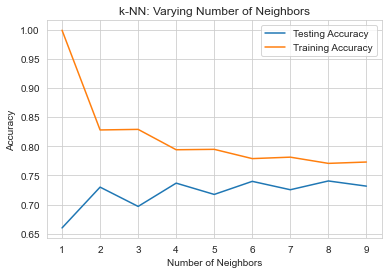

In [605]:
# Setup arrays to store train and test accuracies
# This code is from lecture codes: ML1
neighbors = np.arange(1, 10)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [539]:
# 10-fold CV
knn_params = {"n_neighbors": np.arange(1,10)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, knn_params, cv=10)
knn_cv.fit(X_train, y_train)
print("Best score:" + str(knn_cv.best_score_))
print("Best parameters: " + str(knn_cv.best_params_))

Best score:0.7403336304609971
Best parameters: {'n_neighbors': 8}


In [540]:
# tuned model
knn = KNeighborsClassifier(8)
knn_tuned = knn.fit(X_train, y_train)
knn_tuned.score(X_test, y_test)

0.7404756579437859

In [541]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.89      0.77      0.83     11711
           1       0.19      0.37      0.25      1702

    accuracy                           0.72     13413
   macro avg       0.54      0.57      0.54     13413
weighted avg       0.80      0.72      0.75     13413



## SVM with Binary Class

In [542]:
svm_model = SVC(kernel = "linear").fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.7529262655632595

In [543]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.95      0.77      0.85     12344
           1       0.17      0.52      0.25      1069

    accuracy                           0.75     13413
   macro avg       0.56      0.65      0.55     13413
weighted avg       0.89      0.75      0.80     13413



## Artificial Neural Networks (Binary Class)

In [544]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
mlpc = MLPClassifier().fit(X_train_scaled, y_train)
y_pred = mlpc.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.7443524938492507

In [545]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.89      0.79      0.84     11265
           1       0.31      0.49      0.38      2148

    accuracy                           0.74     13413
   macro avg       0.60      0.64      0.61     13413
weighted avg       0.80      0.74      0.77     13413



# Decision Trees

In [546]:
clf = DecisionTreeClassifier(max_depth=10)
clf_model = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_pred,y_test)

0.7814060985610974

In [547]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.97      0.87     10048
           1       0.72      0.21      0.33      3365

    accuracy                           0.78     13413
   macro avg       0.75      0.59      0.60     13413
weighted avg       0.77      0.78      0.73     13413



In [548]:
#tuning
clf_grid = {"max_depth": range(1,10),
            "min_samples_split" : list(range(2,50))}
clf = tree.DecisionTreeClassifier()
clf_cv = GridSearchCV(clf, clf_grid, cv = 3, n_jobs = -1, verbose = 2)
clf_cv_model = clf_cv.fit(X_train, y_train)
print("Best parameters: " + str(clf_cv_model.best_params_))

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': 9, 'min_samples_split': 44}


In [549]:
clf = tree.DecisionTreeClassifier(max_depth = 9, min_samples_split = 43)
clf_tuned = clf.fit(X_train, y_train)
y_pred = clf_tuned.predict(X_test)
accuracy_score(y_test, y_pred)

0.7827480802206814

In [550]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.97      0.87     10048
           1       0.73      0.21      0.33      3365

    accuracy                           0.78     13413
   macro avg       0.76      0.59      0.60     13413
weighted avg       0.77      0.78      0.73     13413



# Random Forest

In [551]:
rf_model = RandomForestClassifier().fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.7615000372772683

In [552]:
rf_params = {"max_depth": [2,5,8],
            "max_features": [2,5,8],
            "n_estimators": [10,500,1000],
            "min_samples_split": [2,5,10]}

rf_model = RandomForestClassifier()

rf_cv_model = GridSearchCV(rf_model, 
                           rf_params, 
                           cv = 3, 
                           n_jobs = -1, 
                           verbose = 2)
rf_cv_model.fit(X_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 8], 'max_features': [2, 5, 8],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 500, 1000]},
             verbose=2)

In [553]:
print("Best parameters: " + str(rf_cv_model.best_params_))

Best parameters: {'max_depth': 8, 'max_features': 8, 'min_samples_split': 5, 'n_estimators': 10}


In [554]:
rf_tuned = RandomForestClassifier(max_depth = 8, 
                                  max_features = 8, 
                                  min_samples_split = 2,
                                  n_estimators = 10)

rf_tuned.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, max_features=8, n_estimators=10)

In [555]:
y_pred = rf_tuned.predict(X_test)
accuracy_score(y_test, y_pred)

0.7552374561992097

In [556]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86     10048
           1       0.75      0.04      0.07      3365

    accuracy                           0.76     13413
   macro avg       0.75      0.52      0.46     13413
weighted avg       0.75      0.76      0.66     13413



# XGBoost

In [557]:
xgb_model = XGBClassifier().fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8860806680086484

In [558]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.97      0.93     10048
           1       0.89      0.62      0.73      3365

    accuracy                           0.89     13413
   macro avg       0.89      0.80      0.83     13413
weighted avg       0.89      0.89      0.88     13413



### Model Tuning

In [559]:
xgb_params = {
        'n_estimators': [100, 500],
        'subsample': [0.6, 0.8],
        'max_depth': [3, 4],
        'learning_rate': [0.1,0.01],
        "min_samples_split": [2,5]}
xgb = XGBClassifier()

xgb_cv_model = GridSearchCV(xgb, xgb_params, cv = 3, n_jobs = -1, verbose = 2)
xgb_cv_model.fit(X_train, y_train)
xgb_cv_model.best_params_

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[17:48:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "min_samples_split" } are not used.



{'learning_rate': 0.1,
 'max_depth': 4,
 'min_samples_split': 2,
 'n_estimators': 500,
 'subsample': 0.8}

In [560]:
#tuned
xgb = XGBClassifier(learning_rate = 0.1, 
                    max_depth = 4,
                    min_samples_split = 2,
                    n_estimators = 500,
                    subsample = 0.8)
xgb_tuned =  xgb.fit(X_train,y_train)
y_pred = xgb_tuned.predict(X_test)
accuracy_score(y_test, y_pred)

[17:48:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "min_samples_split" } are not used.



0.8738537239991053

In [561]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92     10048
           1       0.88      0.57      0.70      3365

    accuracy                           0.87     13413
   macro avg       0.88      0.77      0.81     13413
weighted avg       0.87      0.87      0.86     13413



# Regressions
Predicting the exact number of citations that a patent will receive

In [562]:
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [563]:
# I will use the data between 1975-2002 for training and testing; then patents between 2003-2022 can be predicted.
model_input_traintest = model_input[(model_input["application_year"]>=1975) & (model_input["application_year"]<=2002)]

#model_input_traintest = model_input_traintest.drop(columns=["patent_id", "count", "application_year"],axis=1)

model_input_predict = model_input[(model_input["application_year"]>=2003) & (model_input["application_year"]<=2022)]
#model_input_predict = model_input_predict.drop(columns=["patent_id", "count", "application_year"], axis=1)

X = model_input_traintest.drop(["patent_id","count","novelty","grant_year"],axis=1)
y = model_input_traintest["count"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=21)

# Lasso

In [564]:
lasso = Lasso(alpha=0.1, normalize=True)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)
lasso.score(X_test, y_test)

-3.187514787050816e-05

In [565]:
lasso_coef = lasso.fit(X,y).coef_
print(lasso_coef)

[ 0.  0. -0.  0.  0. -0. -0. -0. -0.  0. -0.  0. -0. -0.  0. -0. -0. -0.
 -0.  0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0.  0. -0. -0.  0. -0. -0. -0.  0. -0. -0. -0.  0. -0.  0. -0.
 -0. -0. -0. -0. -0. -0.  0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0. -0.  0.  0. -0.  0.  0.
  0.  0.  0.]


In [566]:
np.sqrt(mean_squared_error(y_test, lasso_pred))

49.15208445302655

Text(0, 0.5, 'weights')

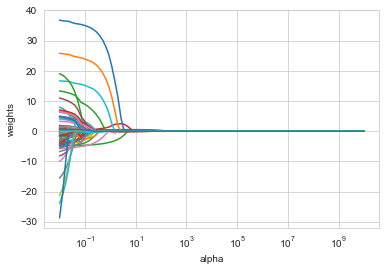

In [567]:
lasso = Lasso()
lambdas = 10**np.linspace(10,-2,100)*0.5 
coefs = []

for i in lambdas:
    lasso.set_params(alpha=i)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(lambdas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

## Model Tuning 

In [568]:
from sklearn.linear_model import LassoCV
lasso_cv_model = LassoCV(alphas = None, 
                         cv = 10, 
                         max_iter = 10000, 
                         normalize = True)
lasso_cv_model.fit(X_train,y_train)
lasso_cv_model.alpha_

0.00036320412214754794

In [569]:
lasso_tuned = Lasso(alpha = lasso_cv_model.alpha_)
lasso_tuned.fit(X_train, y_train)
y_pred = lasso_tuned.predict(X_test)
# making negative predicted values 0
y_pred[y_pred<0] = 0

In [570]:
#RMSE
np.sqrt(mean_squared_error(y_test, y_pred))

47.331052611058404

# Ridge

In [571]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.1, normalize=True)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)
ridge.score(X_test, y_test)

0.07145412775278648

In [572]:
ridge.coef_

array([ 4.09011821e-01,  2.88337101e-02, -4.44476549e+00,  1.72954250e+00,
        2.62334510e-01, -4.32062754e-02, -4.91363628e+00, -1.80817023e+00,
       -5.98533770e+00,  1.05529631e+01, -1.92611978e+00,  1.88816932e+01,
       -7.12294906e+00, -1.29041815e+00,  2.95921031e+00, -3.37437352e+00,
       -8.86447488e+00, -1.85008065e+00,  3.64886378e+00,  1.09006652e+01,
       -3.14863687e+00, -5.44826409e+00,  8.76739491e+00, -3.45955886e+00,
       -4.21881629e-01,  3.48844972e+00, -2.74218579e-01, -7.83476664e+00,
       -7.45944788e+00, -3.07502579e+00, -4.01887496e+00, -4.58389896e+00,
        2.04591474e-01, -6.17622532e-01, -4.62389449e+00, -5.13947190e+00,
       -8.11500505e-01, -2.88890715e+00, -4.40925113e+00,  5.11767076e+01,
       -7.41978901e+00,  7.90567813e-01,  2.01304028e+01,  4.69930598e+00,
        1.90726170e+00,  4.74616933e+00,  1.69715508e+00,  3.15942096e+00,
        0.00000000e+00, -6.79513588e+00,  2.80756803e+01, -3.21156529e+00,
        3.55125086e+00, -

In [573]:
def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()

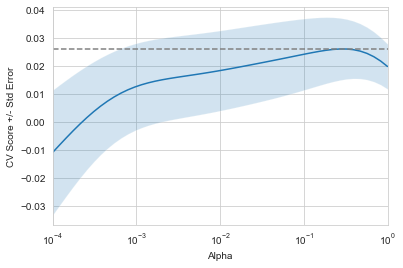

In [574]:
from sklearn.model_selection import cross_val_score
alpha_space = np.logspace(-4, 0, 50)
ridge_scores = []
ridge_scores_std = []

# Create a ridge regressor: ridge
ridge = Ridge(normalize=True)

# Compute scores over range of alphas
for alpha in alpha_space:

    # Specify the alpha value to use: ridge.alpha
    ridge.alpha = alpha
    
    # Perform 10-fold CV: ridge_cv_scores
    ridge_cv_scores = cross_val_score(ridge,X,y,cv=10)
    
    # Append the mean of ridge_cv_scores to ridge_scores
    ridge_scores.append(np.mean(ridge_cv_scores))
    
    # Append the std of ridge_cv_scores to ridge_scores_std
    ridge_scores_std.append(np.std(ridge_cv_scores))

# Display the plot
display_plot(ridge_scores, ridge_scores_std)

In [575]:
max(ridge_scores)

0.02607235888735889

## Model Tuning

In [576]:
from sklearn.linear_model import RidgeCV

lambdas = 10**np.linspace(10,-2,1000)*0.5 
ridge_cv = RidgeCV(alphas = lambdas, 
                   scoring = "neg_mean_squared_error",
                   normalize = True)
ridge_cv.fit(X_train, y_train)
ridge_tuned = Ridge(alpha = ridge_cv.alpha_, 
                   normalize = True).fit(X_train,y_train)

In [577]:
ridge_tuned.coef_

array([ 4.42546779e-01,  1.45349874e-02, -4.80353273e+00,  1.56115966e-01,
        2.85151787e-01, -3.47033369e-02, -4.36978287e+00, -2.85985978e+00,
       -8.07539657e+00,  1.15688992e+01, -4.07774620e+00,  2.07393490e+01,
       -9.82375486e+00, -3.74708423e+00,  4.64472389e-01, -6.15552055e+00,
       -1.07606007e+01, -3.70032790e+00, -2.40108709e+00,  6.61377945e+00,
       -8.36808364e+00, -6.72636253e+00,  2.67473109e+00, -1.21200451e+01,
       -7.57035222e+00, -4.31228545e+00, -1.34949672e+00, -1.14629806e+01,
       -9.32984690e+00, -6.06869268e+00, -6.56415334e+00, -8.74427373e+00,
       -4.53794421e+00, -4.69010304e+00, -7.53632626e+00, -1.08913809e+01,
       -6.97092632e+00, -5.64057822e+00, -1.86327919e+01,  4.86421709e+01,
       -9.57260252e+00, -3.37187271e+00,  1.72816683e+01,  1.47639017e-01,
       -2.39391909e+00, -1.23014983e+00, -1.56138187e-01, -1.09583807e+01,
        0.00000000e+00, -8.33872453e+00,  3.13163603e+01, -6.13328462e+00,
        2.26418702e+00, -

In [578]:
ridge_tuned.score(X_test, y_test)

0.07152654263495861

In [579]:
y_pred = ridge_tuned.predict(X_test)

In [580]:
# making negative predicted values 0
y_pred[y_pred<0] = 0
np.sqrt(mean_squared_error(y_test, y_pred))

47.32940266187699

# Random Forest

In [581]:
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(random_state=42) #number of trees: n_estimators=?

clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Number of Trees used : ', clf.n_estimators)

Number of Trees used :  100


In [582]:
#RMSE
np.sqrt(mean_squared_error(y_test, y_pred))

45.347752440873805

## Model Tuning

In [583]:
rf_params = {'max_depth': list(range(1,5)),
            'max_features': [3,5,10],
            'n_estimators' : [100, 200, 500]}

In [584]:
rf_model = RandomForestRegressor(random_state = 42)
rf_cv_model = GridSearchCV(rf_model, 
                           rf_params, 
                           cv = 3, 
                            n_jobs = -1)

In [585]:
rf_cv_model.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4], 'max_features': [3, 5, 10],
                         'n_estimators': [100, 200, 500]})

In [586]:
# This does not tune the model because RMSE increased.
# This is probably becuase of the parameters that I choose.
# We should try a wider set of parameters which is very costly.
y_pred = rf_cv_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

47.724399868192656

# KNN Regressor

In [587]:
from sklearn.neighbors import KNeighborsRegressor
knn_model = KNeighborsRegressor().fit(X_train, y_train)
y_pred = knn_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

51.31907397897486

## Model Tuning

In [ ]:
#GridSearchCV
knn_params = {'n_neighbors': np.arange(1,30,1)}
knn = KNeighborsRegressor()
knn_cv_model = GridSearchCV(knn, knn_params, cv = 5)
knn_cv_model.fit(X_train, y_train)
knn_tuned = KNeighborsRegressor(n_neighbors = knn_cv_model.best_params_["n_neighbors"])
knn_tuned.fit(X_train, y_train)
y_pred = knn_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred)) #RMSE=48.52. I cleared the output since it was too long.

# ElasticNet

In [589]:
from sklearn.linear_model import ElasticNet
enet_model = ElasticNet().fit(X_train, y_train)
enet_model.coef_

array([ 0.49653132,  0.        , -1.86487429,  2.41404876,  0.12403917,
       -0.25699408, -0.94862751, -0.        , -0.        ,  0.14404079,
       -0.        ,  0.99060294, -0.        ,  0.        ,  0.        ,
       -0.        , -0.11090645, -0.        ,  0.        ,  0.        ,
       -0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        ,  0.        ,  0.        , -0.        ,
       -0.        ,  0.        , -0.        ,  0.        ,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        1.88587816, -0.        ,  0.        , -0.        , -0.        ,
       -0.        ,  0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.  

In [590]:
enet_model.intercept_

-0.9501525564874278

In [591]:
y_pred = enet_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

48.377180869142315

## Model Tuning

In [592]:
from sklearn.linear_model import ElasticNetCV
enet_cv_model = ElasticNetCV(cv = 5, random_state = 0).fit(X_train, y_train)
enet_tuned = ElasticNet(alpha = enet_cv_model.alpha_).fit(X_train,y_train)
y_pred = enet_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

47.890329318016775

# Decision Tree

In [593]:
from sklearn import tree
tree_model = tree.DecisionTreeRegressor(min_samples_split = 2)
tree_model.fit(X_train, y_train)
y_pred =tree_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

59.48624974712387

## Model Tuning

In [594]:
cart_params = {"min_samples_split": range(2,50),
               "max_leaf_nodes": range(2,10)}
cart_cv_model = GridSearchCV(tree_model, cart_params, cv = 5)
cart_cv_model.fit(X_train, y_train)
cart_cv_model.best_params_

{'max_leaf_nodes': 9, 'min_samples_split': 2}

In [595]:
cart_tuned = tree.DecisionTreeRegressor(max_leaf_nodes = 9, min_samples_split = 2)
cart_tuned.fit(X_train, y_train)
y_pred = cart_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

47.939646749487586

# XGBoost

In [596]:
import xgboost as xgb

DM_train = xgb.DMatrix(data = X_train, label = y_train)
DM_test = xgb.DMatrix(data = X_test, label = y_test)
from xgboost import XGBRegressor
xgb_model = XGBRegressor().fit(X_train, y_train)

In [597]:
y_pred = xgb_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

43.64289463567238

## Model Tuning

In [598]:
xgb_grid = {
     'colsample_bytree': [0.4, 0.5,0.9,1], 
     'n_estimators':[100, 200, 500],
     'max_depth': [2,3,4,5],
     'learning_rate': [0.1, 0.01, 0.5]
}

xgb = XGBRegressor()

xgb_cv = GridSearchCV(xgb, 
                      param_grid = xgb_grid, 
                      cv = 3, 
                      n_jobs = -1,
                      verbose = 2)


xgb_cv.fit(X_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estim

In [599]:
y_pred = xgb_cv.predict(X_test) #I cleared this cell's output since it was very long.

In [ ]:
np.sqrt(mean_squared_error(y_test, y_pred)) #RMSE is 43.33. I cleared the output since it was too long